In [1]:
pip install tensorflow opencv-python matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt

# Paths for raw images and ulcer labels
IMG_DIR = "/kaggle/input/raw-images"  # Replace with the URL or local path of raw images
LABEL_DIR = "/kaggle/input/ulcerlabels"  # Replace with the URL or local path of ulcer labels

# Hyperparameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 50

In [3]:
import os
import cv2

def load_data(img_dir, label_dir):
    images = []
    labels = []
    
    # List all files in the image directory
    img_files = sorted(os.listdir(img_dir))
    
    for img_file in img_files:
        # Get the base name (remove the extension) from the image filename
        base_name = os.path.splitext(img_file)[0]
        
        # Construct the corresponding label filename by adding '.png' extension
        label_file = base_name + ".png"
        
        # Build the full paths
        img_path = os.path.join(img_dir, img_file)
        label_path = os.path.join(label_dir, label_file)
        
        # Read and preprocess image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error loading image: {img_path}")
            continue
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        images.append(img)
        
        # Read and preprocess label
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)  # Read label as grayscale (binary image)
        if label is None:
            print(f"Error loading label: {label_path}")
            continue
        label = cv2.resize(label, (IMG_WIDTH, IMG_HEIGHT))
        label = np.expand_dims(label, axis=-1)  # Add channel dimension
        labels.append(label)
    
    images = np.array(images) / 255.0  # Normalize images to [0, 1]
    labels = np.array(labels) / 255.0  # Normalize labels to [0, 1] (binary)
    labels = (labels > 0.5).astype(np.float32)  # Binarize labels (0 or 1)
    return images, labels


In [4]:
pip install tensorflow-gpu


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 126, in _parse_requirement_details
          marker = _parse_requirement_marker(
        File 

In [5]:
import tensorflow as tf

In [6]:

# Load the dataset
images, labels = load_data(IMG_DIR, LABEL_DIR)

# Split dataset into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define the U-Net model
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model


In [7]:

# Create the model
model = unet_model((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Test on new images
def predict_and_visualize(image, model):
    img = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)[0, :, :, 0]
    prediction = (prediction > 0.5).astype(np.uint8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(prediction, cmap="gray")
    plt.show()




Epoch 1/50


I0000 00:00:1733553549.873284      98 service.cc:145] XLA service 0x7f51880027c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733553549.873347      98 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733553549.873353      98 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733553605.436368      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8354 - loss: 0.6606

2024-12-07 06:40:32.696691: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[9,128,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,64,224,224]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-07 06:40:32.932616: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.236059402s
Trying algorithm eng4{k11=1} for conv (f32[9,128,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,64,224,224]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"c

18/18 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.8454 - loss: 0.6534 - val_accuracy: 0.9690 - val_loss: 0.3174
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 558ms/step - accuracy: 0.9691 - loss: 0.3320 - val_accuracy: 0.9690 - val_loss: 0.2044
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 562ms/step - accuracy: 0.9670 - loss: 0.1951 - val_accuracy: 0.9690 - val_loss: 0.1093
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 564ms/step - accuracy: 0.9688 - loss: 0.0995 - val_accuracy: 0.9690 - val_loss: 0.0711
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 567ms/step - accuracy: 0.9669 - loss: 0.0754 - val_accuracy: 0.9690 - val_loss: 0.0640
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 569ms/step - accuracy: 0.9675 - loss: 0.0662 - val_accuracy: 0.9690 - val_loss: 0.0594
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 572ms/step - accuracy: 0.9683 - loss: 0.0574 - val_accuracy: 0.9730 - val_loss: 0.0539
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 574ms/step - accuracy: 0.9733 - loss: 0.0610 - val_accuracy: 0.9806 

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


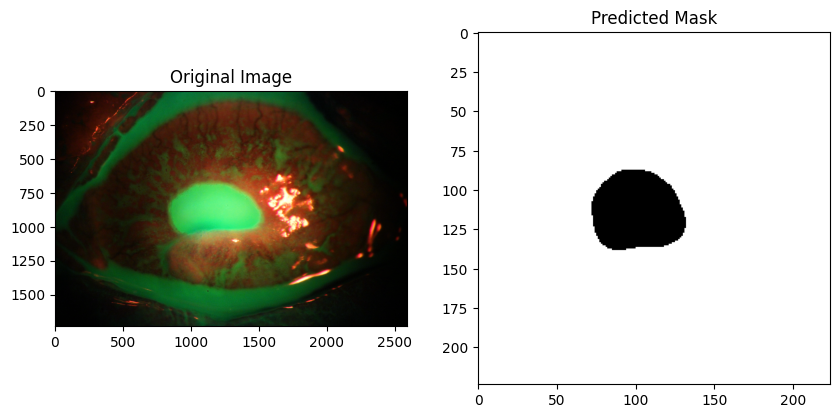

In [8]:
# Example usage
sample_image = cv2.imread("/kaggle/input/test-input/359.jpg")
predict_and_visualize(sample_image, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


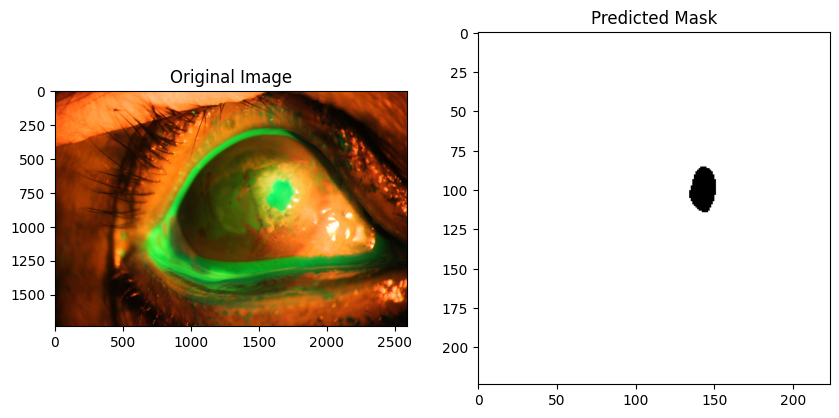

In [9]:
# Example usage
sample_image = cv2.imread("/kaggle/input/test-input/360.jpg")
predict_and_visualize(sample_image, model)

In [10]:
from sklearn.metrics import confusion_matrix

def calculate_metrics(y_true, y_pred):
    # Flatten the masks to 1D for simplicity
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # Binarize predictions (threshold at 0.5)
    y_pred = (y_pred > 0.5).astype(np.uint8)
    
    # Calculate confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    # Global accuracy
    global_accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Sensitivity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    # Jaccard Similarity
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    jaccard_similarity = intersection / union if union > 0 else 0.0
    
    # Dice Similarity Coefficient
    dice_similarity = (2 * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) > 0 else 0.0
    
    return global_accuracy, sensitivity, jaccard_similarity, dice_similarity

# Calculate metrics for all test images
global_accuracies = []
sensitivities = []
jaccard_similarities = []
dice_similarities = []

for i in range(len(x_test)):
    # Predict the mask for a test image
    pred_mask = model.predict(np.expand_dims(x_test[i], axis=0))[0, :, :, 0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize prediction
    
    # Ground truth mask
    true_mask = y_test[i, :, :, 0]
    
    # Compute metrics
    metrics = calculate_metrics(true_mask, pred_mask)
    global_accuracies.append(metrics[0])
    sensitivities.append(metrics[1])
    jaccard_similarities.append(metrics[2])
    dice_similarities.append(metrics[3])

# Compute average metrics
print(f"Global Accuracy: {np.mean(global_accuracies):.4f}")
print(f"Sensitivity: {np.mean(sensitivities):.4f}")
print(f"Jaccard Similarity: {np.mean(jaccard_similarities):.4f}")
print(f"Dice Similarity: {np.mean(dice_similarities):.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Saved prediction mask to /kaggle/working/pred_mask.png


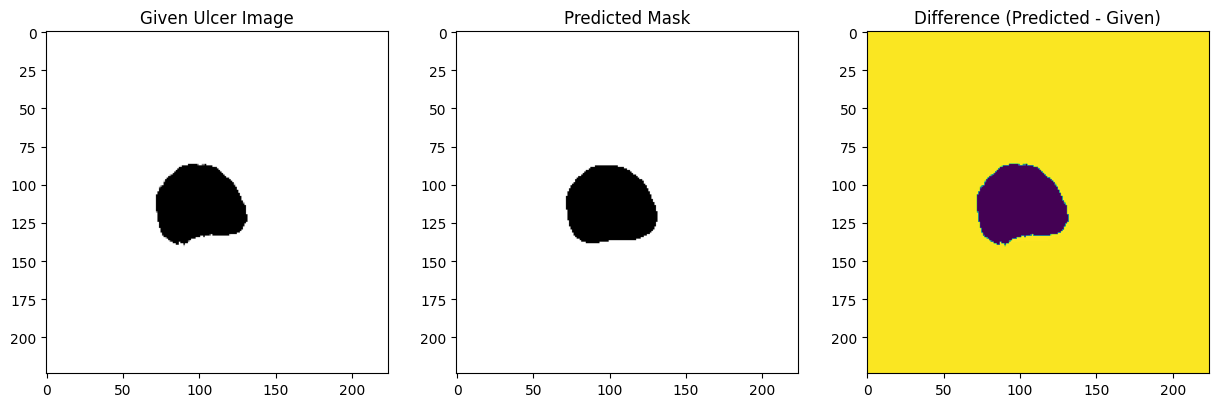

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define the function to save PNG
def save_mask_as_png(mask, file_path):
    mask = (mask * 255).astype(np.uint8)  # Scale mask back to 0-255
    cv2.imwrite(file_path, mask)
    print(f"Saved prediction mask to {file_path}")

# Define predict_and_visualize function
def predict_and_visualize(image, model, ulcer_input_path):
    # Preprocess input image
    img = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Predict the mask
    prediction = model.predict(img)[0, :, :, 0]
    prediction = (prediction > 0.5).astype(np.uint8)

    # Save the predicted mask
    save_mask_as_png(prediction, "/kaggle/working/pred_mask.png")

    # Load the ulcer input image
    ulcer_image = cv2.imread(ulcer_input_path, cv2.IMREAD_GRAYSCALE)
    ulcer_image = cv2.resize(ulcer_image, (IMG_WIDTH, IMG_HEIGHT))

    # Calculate the difference: Predicted mask - Given ulcer input
    difference = cv2.absdiff(prediction, ulcer_image)

    # Plot everything
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Given Ulcer Image")
    plt.imshow(ulcer_image, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(prediction, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Difference (Predicted - Given)")
    plt.imshow(difference, cmap="viridis")

    plt.show()

# Path to input ulcer image
ulcer_input_path = "/kaggle/input/groundtruth/359.png"

# Load the sample input image
sample_image = cv2.imread("/kaggle/input/test-input/359.jpg")
predict_and_visualize(sample_image, model, ulcer_input_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Saved prediction mask to /kaggle/working/pred_mask.png


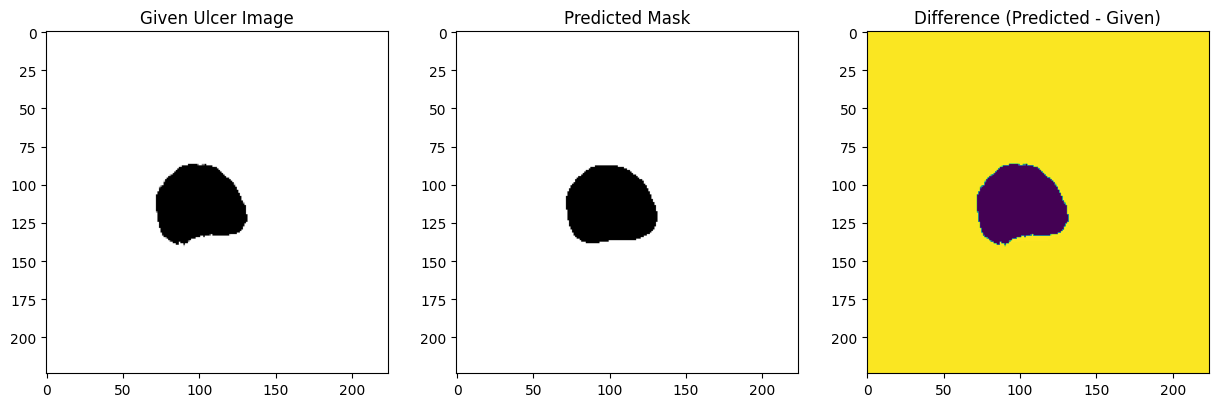

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define the function to save PNG
def save_mask_as_png(mask, file_path):
    mask = (mask * 255).astype(np.uint8)  # Scale mask back to 0-255
    cv2.imwrite(file_path, mask)
    print(f"Saved prediction mask to {file_path}")

# Define predict_and_visualize function
def predict_and_visualize(image, model, ulcer_input_path):
    # Preprocess input image
    img = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Predict the mask
    prediction = model.predict(img)[0, :, :, 0]
    prediction = (prediction > 0.5).astype(np.uint8)

    # Save the predicted mask
    save_mask_as_png(prediction, "/kaggle/working/pred_mask.png")

    # Load the ulcer input image
    ulcer_image = cv2.imread(ulcer_input_path, cv2.IMREAD_GRAYSCALE)
    ulcer_image = cv2.resize(ulcer_image, (IMG_WIDTH, IMG_HEIGHT))

    # Calculate the difference: Predicted mask - Given ulcer input
    difference = cv2.absdiff(prediction, ulcer_image)

    # Plot everything
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Given Ulcer Image")
    plt.imshow(ulcer_image, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(prediction, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Difference (Predicted - Given)")
    plt.imshow(difference, cmap="viridis")

    plt.show()

# Path to input ulcer image
ulcer_input_path = "/kaggle/input/groundtruth/359.png"

# Load the sample input image
sample_image = cv2.imread("/kaggle/input/test-input/359.jpg")
predict_and_visualize(sample_image, model, ulcer_input_path)
